### Prototype Flask App

In [71]:
import os
import glob
from copy import deepcopy

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

from sklearn.metrics.pairwise import cosine_similarity
from keras.models import load_model

%matplotlib inline

Open Relevant Files

In [2]:

watch_names = pd.read_csv('xception_raw_feature_vectors_names.csv',index_col=0)
watch_names['file_name'] = [x.split('/')[-1] for x in watch_names['file_name']]

f_vecs = np.load('xception_raw_feature_vectors.npy')
f_vec_df = pd.DataFrame(f_vecs, index=[watch_names['file_name']])

In [39]:
watch_df = pd.read_csv('all_watch_info_with_indicators.csv')

In [4]:
np.shape(f_vecs)

(7336, 2048)

Compute Cosine Similarities

In [5]:
dists = cosine_similarity(f_vecs) 

In [6]:
np.shape(dists)

(7336, 7336)

In [7]:
dist_df = pd.DataFrame(data = dists)

In [8]:
dist_df.index = watch_names['file_name'].iloc[:]
dist_df.columns = watch_names['file_name'].iloc[:]

Function for finding n closest matches

In [9]:
def get_similar(watchs, n=None):
    """
    calculates which watchs are most similar to the watchs provided. Does not return
    the watchs that were provided
    
    Parameters
    ----------
    watchs: list
        some watchs!
    
    Returns
    -------
    ranked_watchs: list
        rank ordered watchs
    """
    watchs = [watch for watch in watchs if watch in dist_df.columns]
    watchs_summed = dist_df[watchs].apply(lambda row: np.sum(row), axis=1)
    watchs_summed = watchs_summed.sort_values(ascending=False)
    ranked_watchs = watchs_summed.index[watchs_summed.index.isin(watchs)==False]
    ranked_watchs = ranked_watchs.tolist()
    if n is None:
        return ranked_watchs
    else:
        return ranked_watchs[:n]

Random Image from Watch store Database

In [10]:
f_path = 'all_pics/'
f_list = os.listdir(f_path)

(-0.5, 254.5, 399.5, -0.5)

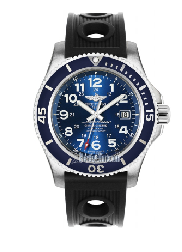

In [11]:
starting_name = np.random.choice(f_list)
img=mpimg.imread(f_path + starting_name)
imgplot = plt.imshow(img)
plt.axis('off')

Recommendations

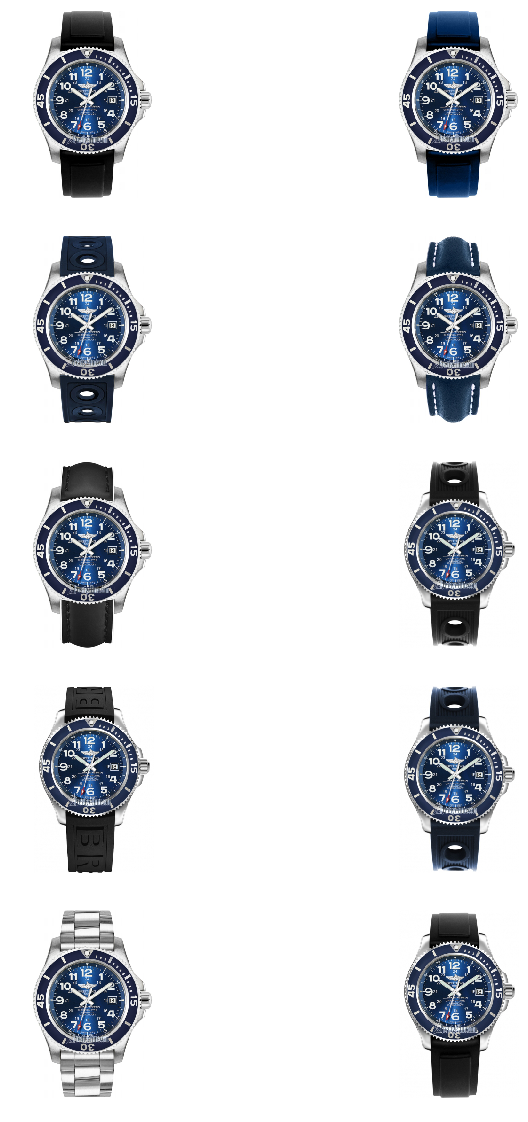

In [46]:
n = 10
recommend_names = get_similar([starting_name],n=n)

r = int(np.ceil(n/2))
c = 2
plt.subplots(nrows=r, ncols=c,figsize=(12,20))

for ix, f_name in enumerate(recommend_names):
    plt.subplot(r,c,ix+1)
    img=mpimg.imread(f_path + f_name.split('/')[-1])
    imgplot = plt.imshow(img)
    plt.axis('off')

__What if the image isn't perfect__

First Load Model

In [13]:
model = load_model('xception_raw_2048.h5')

/home/ubuntu/anaconda3/lib/python3.6/site-packages/keras/models.py:251: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [14]:
def prepare_image(image_path):
    
    im = cv2.imread(image_path)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    im = cv2.resize(im, (299, 299)).astype(np.float32)
    im = im/255
#     im[:,:,0] -= 103.939
#     im[:,:,1] -= 116.779
#     im[:,:,2] -= 123.68
#    im = im.transpose((2,0,1))
    im = np.expand_dims(im, axis=0)
    return im

In [15]:
#img = prepare_image(f_path+starting_name)

In [16]:
test_path = 'test_pics/'
test_files = os.listdir(test_path)

In [17]:
#test_files

In [341]:
#test_file = test_path + np.random.choice(test_files)
#test_file = test_path + 'blogger-image--2007922873.jpg' #
#test_file = test_path +'Bulgari-Octo-Finissimo-Automatic-Thinnest-Titanium-Sand-Blasted-2017-aBlogtoWatch-22.jpg'
test_file = test_path +'cocktail_watch.JPG'
#test_file = test_path +'james_bonds_wrist.png'
#test_file = test_path +'ga054-omega-seamaster-planet-ocean-skyfall.jpg'

(-0.5, 719.5, 479.5, -0.5)

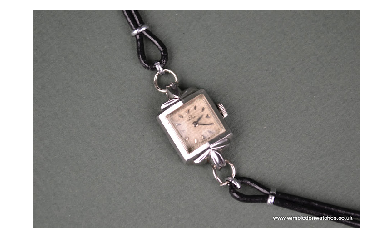

In [342]:
img2show=mpimg.imread(test_file)
imgplot = plt.imshow(img2show)
plt.axis('off')

__match_df__

In [363]:
is_gold = 0
is_silver = 1
is_square = 0
is_round = 0
is_chronograph = 0
is_male = 0

good_rows =  watch_df.loc[(watch_df['is_gold'] == is_gold) & \
            (watch_df['is_silver'] == is_silver) &\
            (watch_df['is_square'] == is_square) &\
            (watch_df['is_round'] == is_round) &\
            (watch_df['is_chronograph'] == is_chronograph) &\
            (watch_df['is_male'] == is_male)]

In [364]:
good_rows = deepcopy(good_rows)
good_recs = [x + '.jpg' for x in good_rows['image_name']]

In [365]:
img = prepare_image(test_file)
out = model.predict(img)

In [366]:
f_vec_df_reduced = f_vec_df.loc[f_vec_df.index.isin(good_recs),:]

In [367]:
similarities = cosine_similarity(out,np.array(f_vec_df_reduced)) 
top_matches = np.array(similarities).argpartition(-n)[0][-n:]
recommend_names = f_vec_df_reduced.index[top_matches]

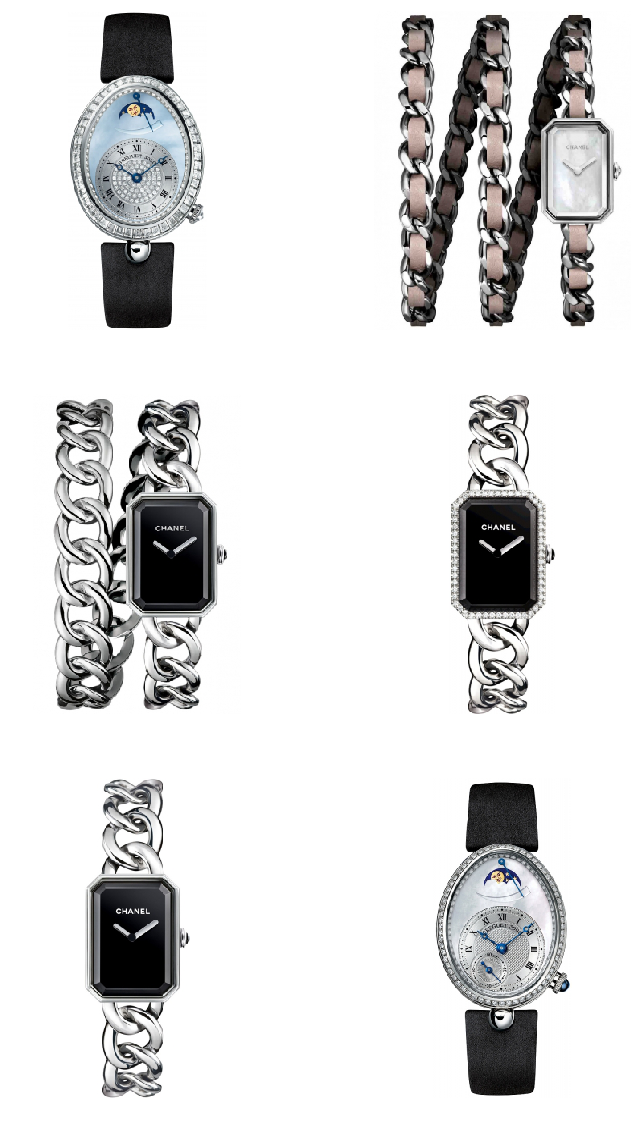

In [368]:
n_recs = 6
r = int(np.ceil(n_recs/2))
c = 2
plt.subplots(nrows=r, ncols=c,figsize=(12,20))

for ix, f_name in enumerate(recommend_names[:n_recs]):
    plt.subplot(r,c,ix+1)
    img=mpimg.imread(f_path + f_name)
    imgplot = plt.imshow(img)
    plt.axis('off')